In [26]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from scipy.sparse import csr_matrix
import matplotlib as mpl
from scipy.integrate import quad, simpson
from numpy.linalg import solve, inv
from scipy.sparse.linalg import bicg
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm, trange
import numba
from scipy.integrate import solve_ivp

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from bachelor_funcs import analytic_green


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

$$\partial_t\Sigma=\frac{3}{r}\partial_r\left[r^{1/2}\partial_r\left(\Sigma r^{1/2}\right)\right]$$
$$\Rightarrow \Sigma(t + Δt) = \Sigma + \Delta t\left[\frac{3}{r}\partial_r\Sigma + 3\partial_r^2\Sigma\right]$$
$$\Rightarrow \left[1 - \Delta t\left(\frac{3}{r}\partial_r + 3 \partial_r^2\right)\right]\Sigma(t+\delta t)
= \Sigma$$
### *Solving $Af=b$*

In [27]:
N = 4001
r_i = 0.01
r_f = 2.1
r = np.linspace(r_i, r_f, N)
Δr = r[1] - r[0]
Δt = 0.0001

D2 = A_matrix(4, 2, N) / Δr**2
D1 = A_matrix(4, 1, N) / Δr

In [28]:
A = np.identity(N) - Δt * (np.diag(3 / r * np.ones(N)) @ D1 + np.diag(3 * np.ones(N)) @ D2)
sA = csr_matrix(A)

In [29]:
τ_step = np.array([0.008, 0.016, 0.032, 0.064, 0.128, 0.256])
t = np.arange(τ_step[0] / 12, τ_step[-1] / 12 + Δt, Δt)
steps = trange(len(t))


Σ0 = analytic_green(r, 0.006)
sol_nobound = []

for step in steps:
    b = Σ0
    res, info = bicg(sA, b, x0 = Σ0)
    sol_nobound.append(res)
    Σ0 = res

100%|██████████| 208/208 [00:02<00:00, 80.23it/s]


In [30]:
i_t = []
for τ in τ_step:
    i_t.append(np.argmin(abs(τ - 12*t)))
i_t
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
t[i_t[0]]*12

0.008

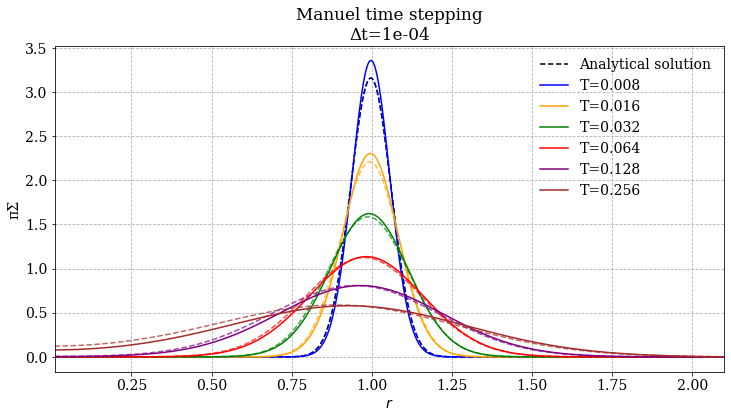

In [31]:
fig, axs = plt.subplots(figsize = (12,6))
plt.grid(ls='--')

axs.plot(r, np.pi *  analytic_green(r, 0.008), label='Analytical solution', c='black', ls='--')

for i, col in zip(i_t, color):
    axs.plot(r, np.pi * sol_nobound[i], label = f'T={t[i]*12:1.3f}', c = col)
    axs.plot(r, np.pi *  analytic_green(r, t[i]*12), c = col, ls='--', alpha=0.7)


axs.set(xlabel='$r$', ylabel='πΣ', title = f'Manuel time stepping\nΔt={Δt:1.0e}', xlim = (r_i, r_f),)
axs.legend(frameon = False)